In [14]:
import pandas as pd
import numpy as np
np.random.seed(0)

import catboost as ctb
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report


from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

import scikitplot as skplt

import matplotlib.pyplot as plt

In [15]:
df_train = pd.read_hdf("../input/train_taiwan.h5")
df_test = pd.read_hdf("../input/test_taiwan.h5")

df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
df_all.columns = [x.replace(" ", "_").lower() for x in df_all.columns]

df_train.shape, df_test.shape, df_all.shape

((3409, 97), (3410, 96), (6819, 97))

In [16]:
# Starter 1 - cechy
num_feats = df_all.select_dtypes("number").columns

black_list = ["target"]
num_feats = [x for x in num_feats if x not in black_list]
num_feats

['roa(c)_before_tax_and_interest_before_depreciation',
 'roa(a)_after_tax_and_before_interest%',
 'roa(b)_after_tax_and_before_interest,_before_depreciation',
 'operating_gross_profit_margin',
 'already_realized_gross_profit_margin_of_sales',
 'operating_profit_rate',
 'net_profit_margin_before_tax',
 'net_profit_margin_after_tax',
 'non-industry_revenue_and_expenditure/revenue',
 'continuous_profit_rate_(after_tax)',
 'business_expense_rate',
 'research_and_development_expense_ratio',
 'cash_flow_ratio',
 'interest-bearing_debt_interest_rate',
 'tax_rate_(a)',
 'book_value_per_share_(b)',
 'book_value_per_share_(a)',
 'book_value_per_share_(c)',
 'persistent_eps_in_the_last_four_seasons',
 'cash_flow_per_share',
 'turnover_per_share_(rmb)',
 'operating_profit_per_share_(rmb)',
 'net_profit_per_share_before_tax_(yuan)',
 'realized_sales_gross_profit_growth_rate',
 'operating_profit_growth_rate',
 'after-tax_net_profit_growth_rate',
 'regular_net_profit_growth_rate',
 'permanent_net_pro

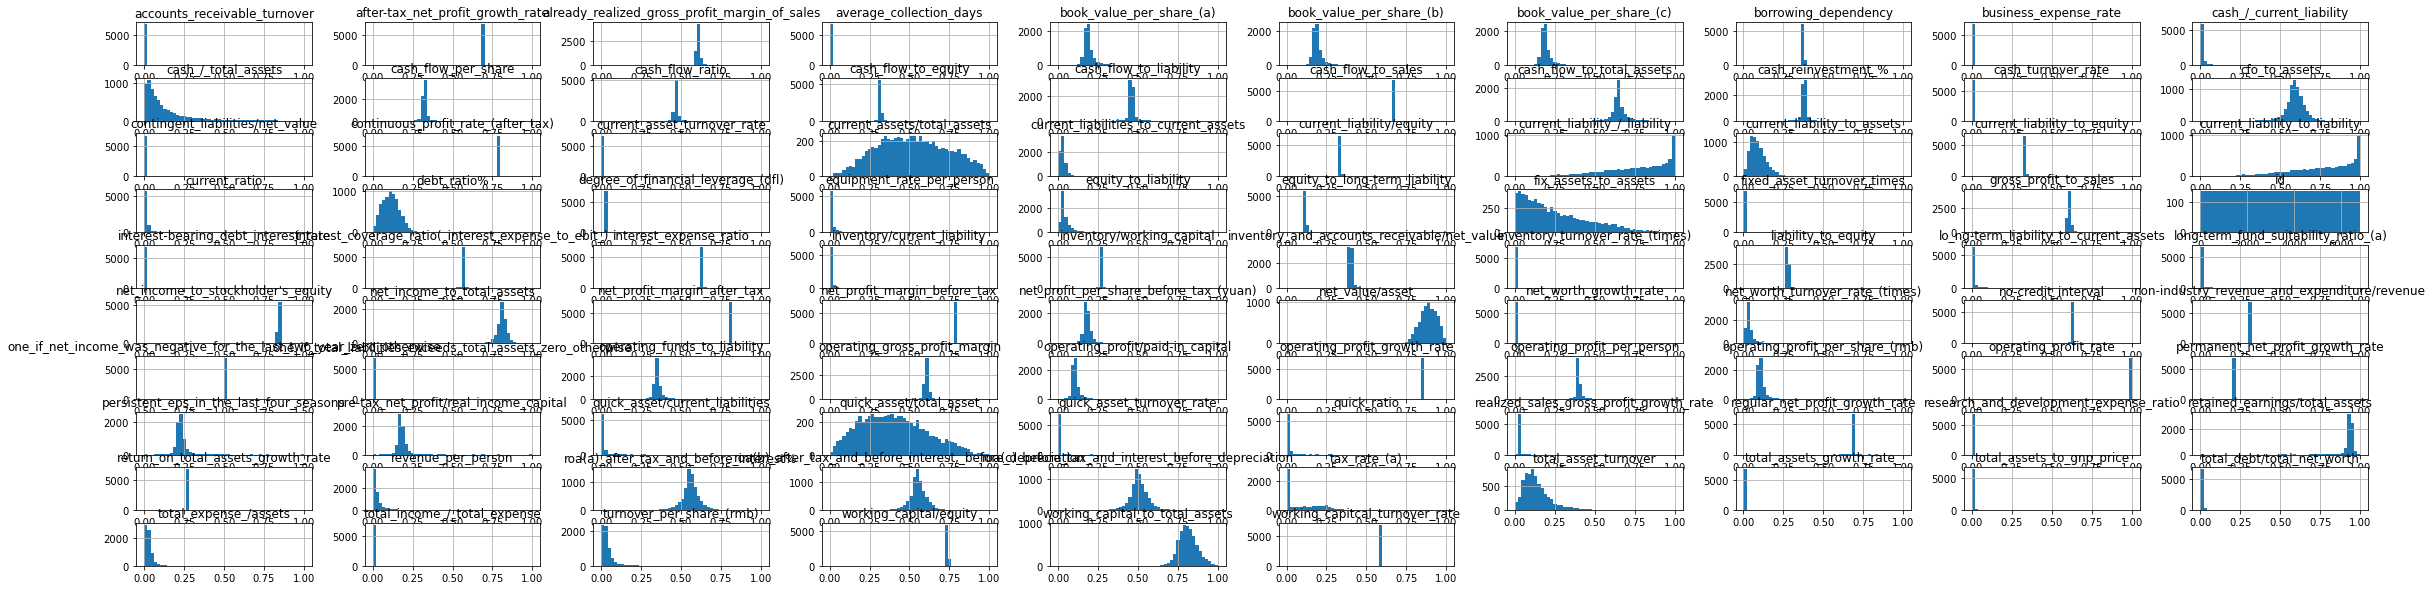

In [17]:
# wykresy dla cech (z df_train), przedtem warto byłoby odrzucić skrajne wartości - było w Starterach - percentile
# (tutaj tego nie zrobiłem)
df_all[ num_feats ].hist(figsize=(40, 10), bins=50);

In [18]:
# cechy, które warto zlogarytmować
df_all['borrowing dependency_log'] = np.log(df_all['borrowing_dependency'])
df_all['Cash / total assets_log'] = np.log(df_all['cash_/_total_assets'])
df_all['Current liability / liability_log'] = np.log(df_all['current_liability_to_equity'])
df_all['Revenue per person_log'] = np.log(df_all['revenue_per_person'])
df_all['Turnover per share (RMB)_log'] = np.log(df_all['turnover_per_share_(rmb)'])
df_all['fix assets to assets_log'] = np.log(df_all['fix_assets_to_assets'])
df_all['total expense /assets_log'] = np.log(df_all['total_expense_/assets'])

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
# funckja pomocnicza ze Startera 3

def make_experiment(model, feats=None, threshold=0.5, n_splits=3, black_list=["target"], show_feats=False, show_cr=False, show_cm=False, show_pr=False, show_lc=False):
    if feats is None:
        num_feats = df_all.select_dtypes("number").columns
        feats = [x for x in num_feats if x not in black_list]

    if show_feats:
        print(feats)
        
    df_train = df_all[ df_all["target"].notnull() ]
    X_train = df_train[feats].values
    y_train = df_train["target"].values

    scores = []
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        #y_pred = model.predict(X_train[test_idx])

        if show_cr:
            print(classification_report(y_train[test_idx], y_pred))
        
        if show_cm:
            skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred)#normalize=True
            
        if show_pr:
            skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)

    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring="f1", random_state=0)
    
    return eli5.show_weights(model, feature_names=feats, top=50)
    
    
def my_hist(df_all, feat_name, left_perc=1, right_perc=99):
    min_value = np.percentile( df_all[feat_name], 1)
    max_value = np.percentile( df_all[feat_name], 99)

    (
        df_all[ 
            (df_all[feat_name] > min_value) &
            (df_all[feat_name] < max_value)
        ][feat_name]
    ).hist(bins=100)
    plt.title("{}\n, left_perc={}, right_perc={}".format(feat_name, left_perc, right_perc))
    plt.show()
    
    
def save_result(filename, model, threshold=0.1):

    df_train = df_all[ df_all["target"].notnull() ]
    df_test = df_all[ df_all["target"].isnull() ].copy()

    num_feats = df_all.select_dtypes("number").columns
    feats = [x for x in num_feats if x not in ["target"]]

    
    model.fit(df_train[feats].values, df_train["target"].values)

    df_test["target"] = (model.predict_proba(df_test[feats].values)[:,1] > 0.1).astype(np.int)
    output_file = "../output/{}".format(filename)
    df_test[ ["id", "target"] ].to_csv(output_file, index=False)
    print("Saved: ", output_file)

In [20]:
# kilka eksperymentów, najlepszy rezultat na Kaggle - lgb ze Startera 3.
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
save_result("lgb_threshold_0.1_sprawdzenie.csv", model)

Saved:  ../output/lgb_threshold_0.1_sprawdzenie.csv
